In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path

import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.transform import resize

In [3]:
from tensorflow.keras import layers
from tensorflow.keras import models

In [4]:
BASE_PATH = Path("..")
sys.path.append(str(BASE_PATH.resolve()))

In [5]:
from src.mobilenetv3.mobilenetv3 import MobileNetV3

In [6]:
tf.__version__

'2.5.0'

In [7]:
from tensorflow.keras.applications import MobileNetV3Small

## CIFAR-10 Dataset

In [8]:
CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [9]:
cifar10 = tf.keras.datasets.cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [10]:
print(train_images.shape, train_labels.shape)

(50000, 32, 32, 3) (50000, 1)


In [11]:
# train_images = np.expand_dims(train_images, axis = 3)
# test_images = np.expand_dims(test_images, axis = 3)

train_images = train_images / 255.
test_images = test_images / 255.

train_labels_onehot = tf.keras.utils.to_categorical(train_labels, num_classes=len(CLASS_NAMES))
test_labels_onehot = tf.keras.utils.to_categorical(test_labels, num_classes=len(CLASS_NAMES))

In [12]:
train_images.shape

(50000, 32, 32, 3)

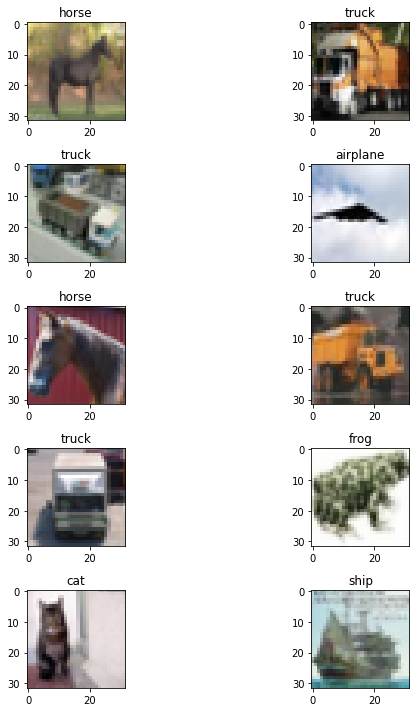

In [13]:
SAMPLE_SIZE = 10
samples = np.random.randint(0, len(train_images), size = SAMPLE_SIZE)

fig, axarr = plt.subplots(5, SAMPLE_SIZE//5, figsize = (10,10))
axs = axarr.ravel()

for idx, sample in enumerate(samples):
    axs[idx].imshow(train_images[sample,:,:,:])
    axs[idx].set_title(CLASS_NAMES[train_labels[sample,0]])
    
plt.tight_layout()

## Train MobilenetV3

In [14]:
ARTEFACT_DIR = Path('./artefacts/mobilenetv3')
if not ARTEFACT_DIR.exists():
    ARTEFACT_DIR.mkdir(parents=True, exist_ok=True)

In [15]:
network_size = 'small'


In [16]:
mobilenetv3 = MobileNetV3(train_images.shape[1:], len(CLASS_NAMES), alpha=1.0, size = network_size)
model = mobilenetv3()


2021-10-27 21:43:48.137367: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
# keras package implementation
# model = MobileNetV3Small(
#     input_shape = train_images.shape[1:], classes=len(CLASS_NAMES),
#     include_top=True, weights = None, classifier_activation='softmax', pooling='avg')


In [18]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00003)
model.compile(optimizer=opt,
          loss=['categorical_crossentropy'],
          metrics=['accuracy'])
    

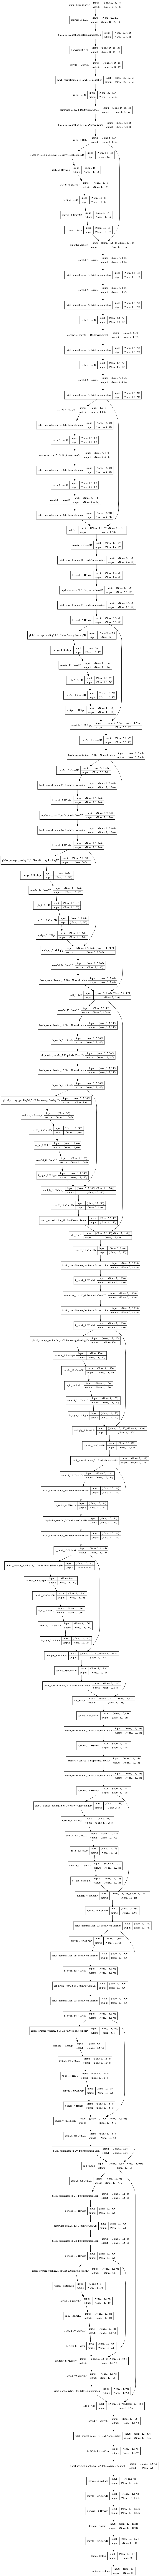

In [19]:
tf.keras.utils.plot_model(model, ARTEFACT_DIR / f"mobilenetv3_{network_size}_info.png", show_shapes=True)


In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
h_swish (HSwish)                (None, 16, 16, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [21]:
model.save(ARTEFACT_DIR / f'mobilenetv3_{network_size}.h5')

/Users/mikheilcircadia/opt/anaconda3/envs/py37-tf250/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [22]:
model.fit(x = train_images, y = train_labels_onehot, validation_split=0.20, verbose=1,epochs = 30)

2021-10-27 21:43:52.776367: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
1250/1250 [==============================] - 111s 84ms/step - loss: 2.2092 - accuracy: 0.1848 - val_loss: 2.1215 - val_accuracy: 0.2334
Epoch 2/30
1250/1250 [==============================] - 108s 86ms/step - loss: 2.0039 - accuracy: 0.2605 - val_loss: 1.9500 - val_accuracy: 0.2922
Epoch 3/30
1250/1250 [==============================] - 110s 88ms/step - loss: 1.8803 - accuracy: 0.3047 - val_loss: 1.8512 - val_accuracy: 0.3257
Epoch 4/30
1250/1250 [==============================] - 101s 81ms/step - loss: 1.7914 - accuracy: 0.3419 - val_loss: 1.7838 - val_accuracy: 0.3474
Epoch 5/30
1250/1250 [==============================] - 104s 84ms/step - loss: 1.7317 - accuracy: 0.3659 - val_loss: 1.7336 - val_accuracy: 0.3648
Epoch 6/30
1250/1250 [==============================] - 101s 81ms/step - loss: 1.6809 - accuracy: 0.3819 - val_loss: 1.6864 - val_accuracy: 0.3860
Epoch 7/30
1250/1250 [==============================] - 98s 79ms/step - loss: 1.6305 - accuracy: 0.4007 - val_loss: 1.

## Evaluate MobilenetV3

In [23]:
test_loss, test_acc = model.evaluate(test_images,  test_labels_onehot, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 3s - loss: 1.5530 - accuracy: 0.4605

Test accuracy: 0.46050000190734863
